In [2]:
import os
import random
import foolbox
import matplotlib
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.preprocessing import image

from keras.optimizers import SGD,RMSprop,adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Data Loader

In [6]:
listing = os.listdir("dataset/train_data/train_2/")

3500

In [7]:
img_rows, img_cols = 200, 200

In [ ]:
immatrix = []
imlabel = []

with tqdm(listing) as pbar:
    for file in listing:
        base = os.path.basename("dataset/train_data/train_2/" + file)
        fileName = os.path.splitext(base)[0]
        if trainLabels.loc[trainLabels.image==fileName, 'level'].values[0] == 0:
            imlabel.append(0)
        else:
            imlabel.append(1)
        im = Image.open("dataset/train_data/train_2/" + file)   
        img = im.resize((img_rows,img_cols))
        gray = img.convert('L')
        immatrix.append(np.array(gray).flatten())
        pbar.update(1)

immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)

In [ ]:
np.save('immatrix_binary.npy', immatrix)
np.save('imlabel_binary.npy', imlabel)

In [8]:
immatrix = np.load('immatrix_binary.npy')
imlabel = np.load('imlabel_binary.npy')

## Data Preprocessing

In [9]:
data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]

list

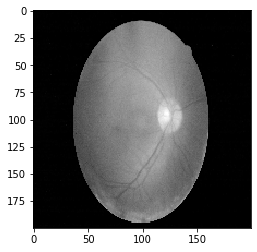

In [10]:
img=immatrix[200].reshape(img_rows,img_cols)
plt.imshow(img)
plt.imshow(img,cmap='gray')

In [11]:
batch_size = 48
nb_classes = 2
nb_epoch = 100
nb_filters = 32
nb_pool = 2
nb_conv = 3

(X, y) = (train_data[0],train_data[1])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(2800, 40000)
(700, 40000)
X_train shape: (2800, 200, 200, 1)
2800 train samples
700 test samples


In [13]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## CNN Model Definition

In [14]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(200, 200,..., padding="valid")`
  """
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  


In [15]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 196, 196, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)           

### Data Augmentation

In [16]:
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batch_size) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batch_size)

## Training

In [73]:
history_1 = model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=nb_epoch, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/100
58/58 [==============================] - 69s 1s/step - loss: 0.6333 - accuracy: 0.7820 - val_loss: 0.4570 - val_accuracy: 0.8244
Epoch 2/100
58/58 [==============================] - 70s 1s/step - loss: 0.5112 - accuracy: 0.7976 - val_loss: 0.4891 - val_accuracy: 0.8098
Epoch 3/100
58/58 [==============================] - 72s 1s/step - loss: 0.4991 - accuracy: 0.7936 - val_loss: 0.5746 - val_accuracy: 0.8113
Epoch 4/100
58/58 [==============================] - 69s 1s/step - loss: 0.4908 - accuracy: 0.7969 - val_loss: 0.4629 - val_accuracy: 0.8129
Epoch 5/100
58/58 [==============================] - 68s 1s/step - loss: 0.4767 - accuracy: 0.7947 - val_loss: 0.3614 - val_accuracy: 0.8298
Epoch 6/100
58/58 [==============================] - 71s 1s/step - loss: 0.4635 - accuracy: 0.7945 - val_loss: 0.3325 - val_accuracy: 0.8129
Epoch 7/100
58/58 [==============================] - 68s 1s/step - loss: 0.4630 - accuracy: 0.7941 - val_loss: 0.3316 - val_accuracy: 0.8236
Epoch 8/100
5

Epoch 60/100
58/58 [==============================] - 67s 1s/step - loss: 0.3985 - accuracy: 0.8034 - val_loss: 0.3924 - val_accuracy: 0.8374
Epoch 61/100
58/58 [==============================] - 66s 1s/step - loss: 0.3969 - accuracy: 0.8089 - val_loss: 0.3688 - val_accuracy: 0.8333
Epoch 62/100
58/58 [==============================] - 64s 1s/step - loss: 0.3870 - accuracy: 0.8125 - val_loss: 0.3974 - val_accuracy: 0.8420
Epoch 63/100
58/58 [==============================] - 65s 1s/step - loss: 0.3854 - accuracy: 0.8161 - val_loss: 0.2914 - val_accuracy: 0.8405
Epoch 64/100
58/58 [==============================] - 67s 1s/step - loss: 0.3661 - accuracy: 0.8281 - val_loss: 0.3793 - val_accuracy: 0.8574
Epoch 65/100
58/58 [==============================] - 65s 1s/step - loss: 0.3707 - accuracy: 0.8219 - val_loss: 0.2924 - val_accuracy: 0.8819
Epoch 66/100
58/58 [==============================] - 65s 1s/step - loss: 0.3587 - accuracy: 0.8372 - val_loss: 0.2329 - val_accuracy: 0.8528
Epoch 

### Training Loss Plot

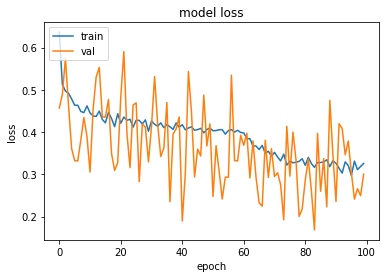

In [74]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Training Accuracy Plot

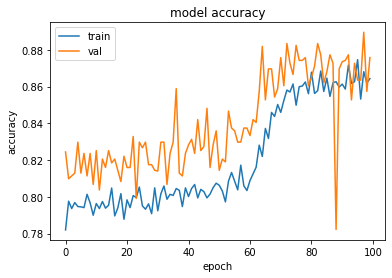

In [75]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [76]:
model.save("model_original_48_100_3500_binary.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model = load_model('model_original_48_100_3500_binary.h5')
model.trainable=False

## Evaluation - Model Loss & Accuracy

In [77]:
scores = model.evaluate(X_test, Y_test)
print(scores)

700/700 [==============================] - 2s 2ms/step
[0.2868469100339072, 0.8742856979370117]


### Confusion Matrix

In [78]:
y_pred = model.predict(X_test)

confusion_matrix(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1))

array([[ 77,  37],
       [ 51, 535]])

### Precision, Recall & F1 Score - Classification Report

In [79]:
print(classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       114
           1       0.94      0.91      0.92       586

    accuracy                           0.87       700
   macro avg       0.77      0.79      0.78       700
weighted avg       0.88      0.87      0.88       700



### Accuracy

In [80]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  87.42857142857143


## Training

In [81]:
history_2 = model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=nb_epoch, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/100
58/58 [==============================] - 66s 1s/step - loss: 0.3303 - accuracy: 0.8630 - val_loss: 0.2768 - val_accuracy: 0.8750
Epoch 2/100
58/58 [==============================] - 64s 1s/step - loss: 0.3141 - accuracy: 0.8670 - val_loss: 0.1928 - val_accuracy: 0.8727
Epoch 3/100
58/58 [==============================] - 65s 1s/step - loss: 0.3238 - accuracy: 0.8630 - val_loss: 0.1845 - val_accuracy: 0.8773
Epoch 4/100
58/58 [==============================] - 67s 1s/step - loss: 0.3156 - accuracy: 0.8725 - val_loss: 0.3621 - val_accuracy: 0.8635
Epoch 5/100
58/58 [==============================] - 68s 1s/step - loss: 0.3223 - accuracy: 0.8676 - val_loss: 0.2472 - val_accuracy: 0.8773
Epoch 6/100
58/58 [==============================] - 68s 1s/step - loss: 0.3110 - accuracy: 0.8717 - val_loss: 0.3368 - val_accuracy: 0.8819
Epoch 7/100
58/58 [==============================] - 66s 1s/step - loss: 0.3080 - accuracy: 0.8685 - val_loss: 0.3307 - val_accuracy: 0.8727
Epoch 8/100
5

Epoch 59/100
58/58 [==============================] - 66s 1s/step - loss: 0.3021 - accuracy: 0.8783 - val_loss: 0.2136 - val_accuracy: 0.8834
Epoch 60/100
58/58 [==============================] - 63s 1s/step - loss: 0.3072 - accuracy: 0.8732 - val_loss: 0.2323 - val_accuracy: 0.8696
Epoch 61/100
58/58 [==============================] - 66s 1s/step - loss: 0.2998 - accuracy: 0.8790 - val_loss: 0.1827 - val_accuracy: 0.8735
Epoch 62/100
58/58 [==============================] - 66s 1s/step - loss: 0.3120 - accuracy: 0.8725 - val_loss: 0.2994 - val_accuracy: 0.8543
Epoch 63/100
58/58 [==============================] - 63s 1s/step - loss: 0.3014 - accuracy: 0.8761 - val_loss: 0.2496 - val_accuracy: 0.8788
Epoch 64/100
58/58 [==============================] - 66s 1s/step - loss: 0.3049 - accuracy: 0.8735 - val_loss: 0.1247 - val_accuracy: 0.8742
Epoch 65/100
58/58 [==============================] - 86s 1s/step - loss: 0.3039 - accuracy: 0.8714 - val_loss: 0.3341 - val_accuracy: 0.8758
Epoch 

### Training Loss Plot

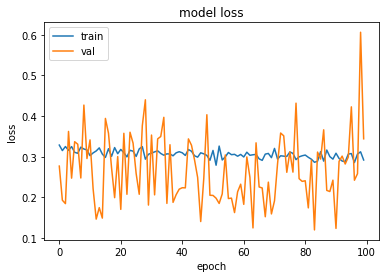

In [82]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training Accuracy Plot

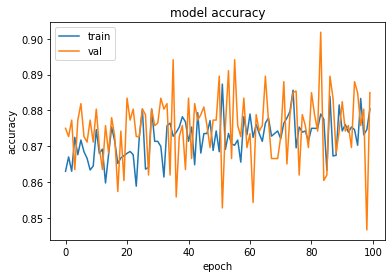

In [83]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
model.save("model_original_48_200_3500_binary.h5")
print("Saved model to disk")

Saved model to disk


## Evaluation - Model Loss & Accuracy

In [85]:
scores = model.evaluate(X_test, Y_test)
print(scores)

700/700 [==============================] - 2s 3ms/step
[0.2915324205160141, 0.8757143020629883]


### Confusion Matrix

In [86]:
y_pred = model.predict(X_test)

confusion_matrix(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1))

array([[ 89,  48],
       [ 39, 524]])

### Precision, Recall & F1 Score - Classification Report

In [87]:
print(classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       137
           1       0.92      0.93      0.92       563

    accuracy                           0.88       700
   macro avg       0.81      0.79      0.80       700
weighted avg       0.87      0.88      0.87       700



### Accuracy

In [88]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  87.57142857142857


In [89]:
hist1_df = pd.DataFrame(history_1.history)
hist_json_file = 'binary_history_1.json' 
with open(hist_json_file, mode='w') as f:
    hist1_df.to_json(f)

In [90]:
hist2_df = pd.DataFrame(history_2.history)
hist_json_file = 'binary_history_2.json' 
with open(hist_json_file, mode='w') as f:
    hist2_df.to_json(f)

# Adversarial Attacks

In [17]:
loadedModel = load_model("model_original_48_200_3500_binary.h5")
loadedModel.trainable = False

In [18]:
fmodel = foolbox.models.KerasModel(loadedModel, bounds=(0, 255))
print("Mean Accuracy for Predictions on Original Data: {0:.2f}%".format(np.mean(fmodel.forward(X_test).argmax(axis=1) == Y_test.argmax(axis=1)) * 100))

Mean Accuracy for Predictions on Original Data: 87.57%


## 1. FGSM Attack

In [19]:
# (a) attack 1

attack_1 = foolbox.attacks.FGSM(fmodel)
adversarials_1 = attack_1(X_test, Y_test.argmax(axis=1))
print("Mean Accuracy for Predictions on Perturbed Data by FGSM Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_1).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by FGSM Attack: 60.14%


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


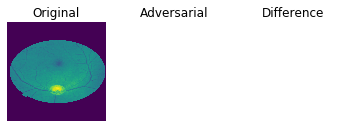

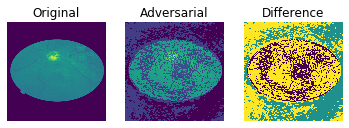

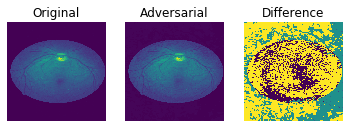

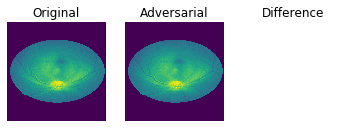

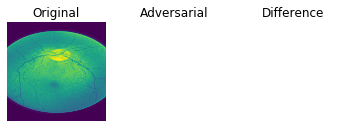

In [29]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_1[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 2. Spatial Attack

In [24]:
# (a) attack 2

attack_2 = foolbox.attacks.SpatialAttack(fmodel)
adversarials_2 = attack_2(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Spatial Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_2).argmax(axis=-1) == Y_test.argmax(axis=-1)) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Spatial Attack: 72.86%


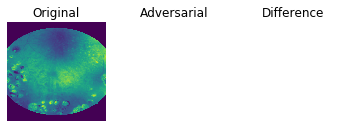

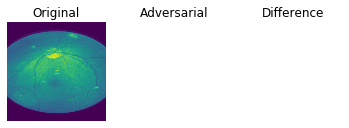

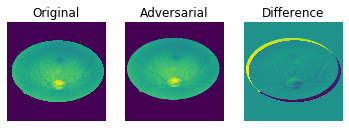

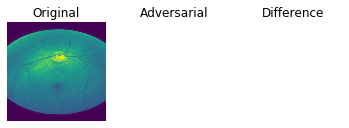

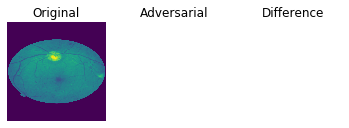

In [37]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_2[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 3. Deep Fool Attack

In [ ]:
# (a) attack 3

attack_3 = foolbox.attacks.DeepFoolAttack(fmodel)
adversarials_3 = attack_3(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Deep Fool Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_3).argmax(axis=-1) == y_test) * 100))

In [ ]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_3[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 4. Inversion Attack

In [110]:
# (a) attack 4

attack_4 = foolbox.attacks.InversionAttack(fmodel)
adversarials_4 = attack_4(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Inversion Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_4).argmax(axis=-1) == y_test) * 100))

Mean Accuracy for Predictions on Perturbed Data by Inversion Attack: 74.86%


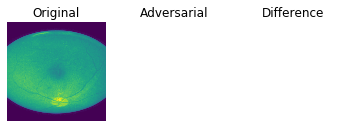

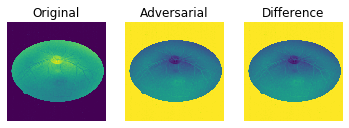

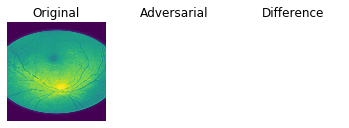

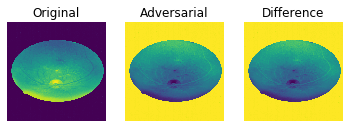

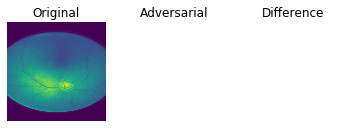

In [112]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_4[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 5. Gaussian Blur Attack

In [30]:
# (a) attack 5

attack_5 = foolbox.attacks.GaussianBlurAttack(fmodel)
adversarials_5 = attack_5(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by Gaussian Blur Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_5).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: GaussianBlurAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Gaussian Blur Attack: 70.43%


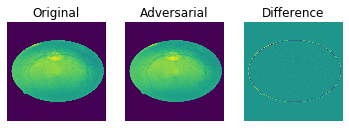

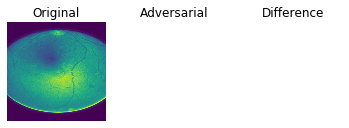

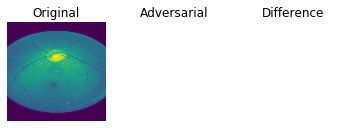

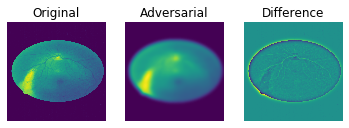

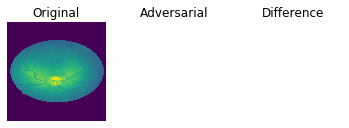

In [32]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_5[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()

## 6. Pointwise Scoring Attack

In [17]:
# (a) attack 6

attack_6 = foolbox.attacks.PointwiseAttack(fmodel)
adversarials_6 = attack_6(X_test, Y_test.argmax(axis=1))

print("Mean Accuracy for Predictions on Perturbed Data by PointWise Attack: {0:.2f}%".format(np.mean(fmodel.forward(adversarials_6).argmax(axis=-1) == y_test) * 100))

/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: SaltAndPepperNoiseAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/pointwise.py:57: UserWarning: Initialization failed. If the criterion is targeted, it might be necessary to pass an explicit starting point or targeted initialization attack.
  "Initialization failed. If the criterion is targeted,"
/localhome/team2/.local/lib/python3.6/site-packages/foolbox/attacks/base.py:95: UserWarning: PointwiseAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Mean Accuracy for Predictions on Perturbed Data by Gaussian Blur Attack: 74.86%


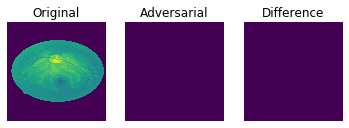

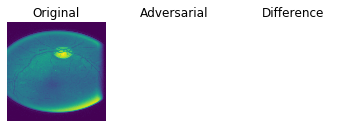

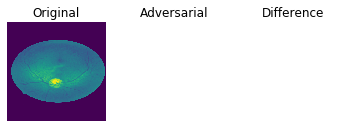

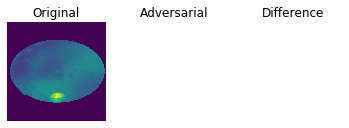

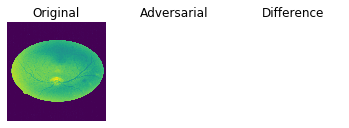

In [23]:
random_sample = random.sample(range(0, len(X_test)), 5)
for number in random_sample:
    image = X_test[number]
    image = image.transpose(1, 2, 0)
    image = image.reshape(img_rows, img_cols)
    adversarial = adversarials_6[number]
    adversarial = adversarial.transpose(1, 2, 0)
    adversarial = adversarial.reshape(img_rows, img_cols)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

plt.show()